In [1]:
!pip install Mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 313.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [70]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from tqdm import tqdm
import itertools

from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor


import xgboost as xgb
import matplotlib.pyplot as plt
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from tqdm import tqdm
import itertools
%matplotlib inline
import mesa
import random
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

from multiprocessing import Pool
from datetime import datetime

from mesa.time import SimultaneousActivation
from sklearn.cluster import DBSCAN
from mesa.datacollection import DataCollector
from mesa.time import StagedActivation
import seaborn as sns
import os

from multiprocessing import Pool
import matplotlib.pyplot as plt
from datetime import datetime
import warnings


In [4]:
class DeffuantAgent(Agent):
    """
    Class representing agent in Deffuant Model. Can interact in
    pairwise or all-with-all manner.
    Source: https://www.jasss.org/5/4/1.html
    """

    def __init__(self, unique_id, opinion, uncertainty, intensity_interaction, model):
        super().__init__(unique_id, model)
        self.opinion = opinion
        self.uncertainty = uncertainty
        self.intensity_interaction = intensity_interaction
        self.model = model
        self.n_agents = self.model.n_agents
        self._interacted = [False] * self.n_agents
        self._interacted[self.unique_id] = True
        self._ids = [i for i in range(self.n_agents)]
        self._opinion_delta = 0
        self._uncertainty_delta = 0

    def _interact(self, agent):
        """Implements interaction logic in Deffuant model.
        Computes overlap in opinion ± uncertainty of both agents and its
        relative agreement. Adds delta opinion and uncertainty on pre-step.

        Parameters
        ----------
        agent : DeffuantAgent
            agent with which it should interact

        Returns
        -------
        None
        """
        overlap = min(self.opinion + self.uncertainty, agent.opinion + agent.uncertainty) - max(self.opinion - self.uncertainty, agent.opinion - agent.uncertainty)
        relative_agreement = max(0, overlap / self.uncertainty - 1)
        multiplier = 1 if self.model.mode == "pairwise" else 1 / (self.n_agents - 1)
        self._opinion_delta += multiplier * self.intensity_interaction * relative_agreement * (agent.opinion - self.opinion)
        self._uncertainty_delta += multiplier * self.intensity_interaction * relative_agreement * (agent.uncertainty - self.uncertainty)
        self._interacted[agent.unique_id] = True
        agent._interacted[self.unique_id] = True

    def _pair(self, population):
        """Choose pair for an agent according to the mode.
        If it is "pairwise", then chooses only one agent, otherwise
        returns entire population with which it has not interaction on pre-step.

        Parameters
        ----------
        population : list
            list of agents in Mesa scheduler

        Returns
        -------
        pairs : list
            list of paired agents
        """
        pairs = []
        shuffled = random.sample(self._ids, self.n_agents)
        for agent_idx in shuffled:
            if not population[agent_idx]._check_interaction(idx=self.unique_id):
                pairs.append(population[agent_idx])
                if self.model.mode == "pairwise":
                    break
        return pairs

    def step(self):
        """Step function for agent in Mesa.
        Performs interaction with chosen pairs of agents if not already.
        """
        if self._check_interaction():
            return
        population = self.model.schedule.agents
        agents = self._pair(population)
        for agent in agents:
            self._interact(agent)
            agent._interact(self)

    def _check_interaction(self, idx=None):
        """Check whether the agent has interacted with other agents.

        Parameters
        ----------
        idx : None or int
            id of agent with which to check the interaction

        Returns
        -------
        has_interacted : bool
            True if agent had interaction, False - otherwise
        """
        if idx is not None:
            return self._interacted[idx]
        if self.model.mode == "pairwise":
            return self._interacted.count(True) == 2
        has_interacted = self._interacted.count(True) == len(self._interacted)
        return has_interacted

    def advance(self):
        """Implementation of prestep function for simultaneous activation in Mesa."""
        self.opinion = min(1, max(-1, self.opinion + self._opinion_delta))
        self.uncertainty = max(1e-3, self.uncertainty + self._uncertainty_delta)
        self._interacted = [False] * self.n_agents
        self._interacted[self.unique_id] = True
        self._opinion_delta = 0
        self._uncertainty_delta = 0

In [5]:
class DeffuantModel(Model):
    """
    Class representing Deffuant Model in Mesa.
    Can be considered as a spawn point for agents and object that
    keeps track of simulation.
    Sets up agent population according to the user-defined level of uncertainty
    for extremists and moderate, propotion of extremists, relative difference of
    positive and negative extremists and intensity interaction.
    Supports pairwise and all-with-all types of interactions.
    """

    def __init__(self,
                 n_agents=1000,
                 percentage_extremists=0.07,
                 uncertainty_moderate=0.5,
                 uncertainty_extremists=0.1,
                 relative_difference_positive_negative_extrimists=0,
                 intensity_interaction=0.5,
                 mode="pairwise"
                ):
        assert n_agents % 2 == 0, "Number of agents must be even!"
        assert mode == "pairwise" or mode == "all-with-all", 'Mode is either "pairwise" or "all-with-all"'

        super().__init__()

        self.n_agents = n_agents
        self.percentage_extremists = percentage_extremists
        self.uncertainty_moderate = uncertainty_moderate
        self.uncertainty_extremists = uncertainty_extremists

        propotion_positive_negative_extremists = - (1 + relative_difference_positive_negative_extrimists) / (relative_difference_positive_negative_extrimists - 1)
        self.propotion_positive_negative_extremists = propotion_positive_negative_extremists
        self.intensity_interaction = intensity_interaction
        self.mode = mode
        self.schedule = SimultaneousActivation(self)
        self.history = []

        self._derive_parameters()
        self._create_agents()

    def get_state(self):
        """Get array of opinions on current step."""
        return np.array([a.opinion for a in self.schedule.agents])

    def step(self):
        """Step in Mesa simulation."""
        state = self.get_state()
        self.history.append(state)
        self.schedule.step()

    def _derive_parameters(self):
        """Derives number of positive, negative extremists and moderate
        agents according to user-defined paramters.
        """
        self.n_extremists = int(self.n_agents * self.percentage_extremists)
        propotion = self.propotion_positive_negative_extremists
        percentage_positive_extremists = propotion / (1 + propotion)
        self.n_moderate = self.n_agents - self.n_extremists
        self.n_positive_extremists = int(self.n_extremists * percentage_positive_extremists)
        self.n_negative_extremists = self.n_extremists - self.n_positive_extremists

    def _create_agents(self):
        """Create agents for Mesa simulation. Generates set of initial
        opinions from uniform distribution. Splits this set into three subsets of
        positive, negative extrimists and moderate. Instantiate objects of type
        DeffuanAgent with generated opinions and correspondent uncertainty level.
        Adds agents to the Mesa scheduler.
        """
        agents = []
        opinions = np.random.uniform(-1, 1, self.n_agents)
        opinions.sort()

        positive_opinions = opinions[-self.n_positive_extremists:]
        negative_opinions = opinions[:self.n_negative_extremists]
        moderate_opinions = opinions[self.n_negative_extremists:-self.n_positive_extremists]

        for opinion in positive_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_extremists, self.intensity_interaction, self)
            agents.append(a)

        for opinion in negative_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_extremists, self.intensity_interaction, self)
            agents.append(a)

        for opinion in moderate_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_moderate, self.intensity_interaction, self)
            agents.append(a)

        for agent in agents:
            self.schedule.add(agent)


In [6]:
def run_simulation(n_agents=200, iterations=100, mode="pairwise", verbose=False):

    model = DeffuantModel(n_agents=n_agents, mode=mode)
    iterator = tqdm(range(iterations)) if not verbose else range(iterations)
    for _ in iterator:
        model.step()
    return model

In [7]:
def plot_chart(model):

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Opinion Segmentation ({model.mode})")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Opinion")
    history = model.history
    ax1.plot(np.arange(1, len(history) + 1), np.array(history), '-')
    plt.xlim([1, len(history)])
    plt.ylim([-1, 1])
    plt.show()

/usr/local/lib/python3.10/dist-packages/mesa/time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)
100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


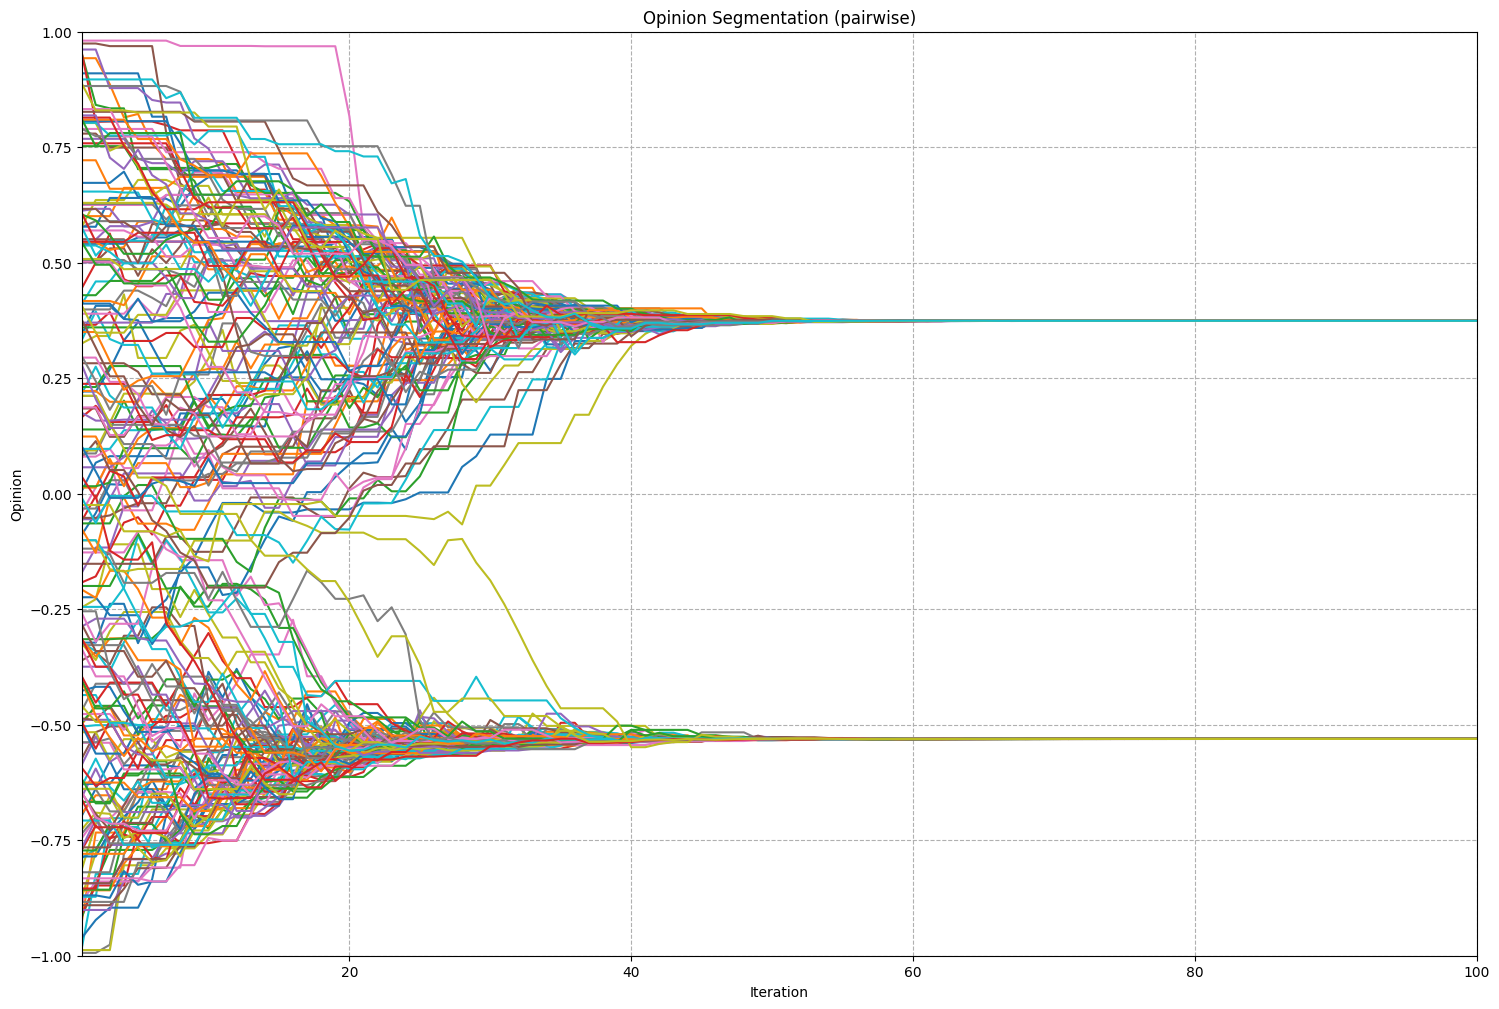

In [8]:
model = run_simulation(mode="pairwise")
plot_chart(model)

100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


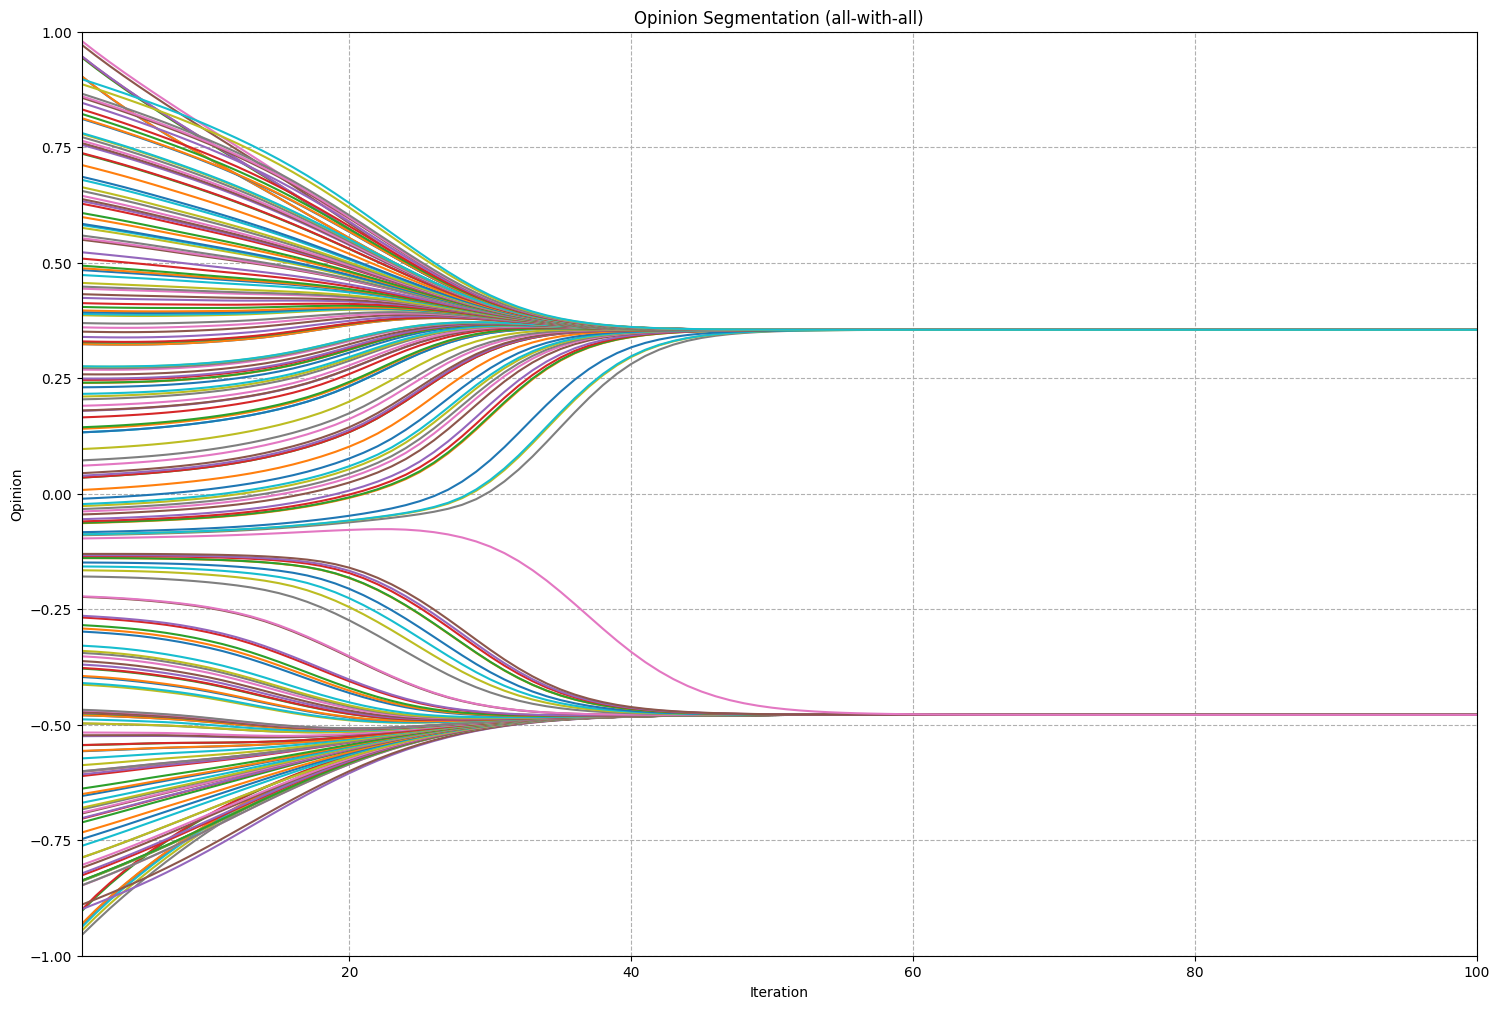

In [9]:
model = run_simulation(mode="all-with-all")
plot_chart(model)

In [10]:
def check_convergence(values, max_offset, eps):

    values = np.array(values)
    if values.shape[0] < max_offset + 1:
        return False
    differences = np.zeros((max_offset, values.shape[1]))
    for idx, offset in enumerate(range(2, max_offset + 2)):
        differences[idx] = values[-1] - values[-offset]
    has_converged = (differences < eps).all()
    return has_converged

In [11]:
def run_until_converge(n_agents=1000,
                       max_iterations=300,
                       max_offset=5,
                       eps=5e-3,
                       percentage_extremists=0.07,
                       uncertainty_moderate=0.5,
                       uncertainty_extremists=0.1,
                       relative_difference_positive_negative_extrimists=0,
                       intensity_interaction=0.5,
                       mode="pairwise"):

    kwargs = {
        'percentage_extremists': percentage_extremists,
        'uncertainty_moderate': uncertainty_moderate,
        'uncertainty_extremists': uncertainty_extremists,
        'relative_difference_positive_negative_extrimists': relative_difference_positive_negative_extrimists,
        'intensity_interaction': intensity_interaction,
        'mode': mode,
        'n_agents': n_agents
    }
    model = DeffuantModel(**kwargs)
    i = 0
    while not check_convergence(model.history, max_offset, eps) and i < max_iterations:
        model.step()
        i += 1
    return model

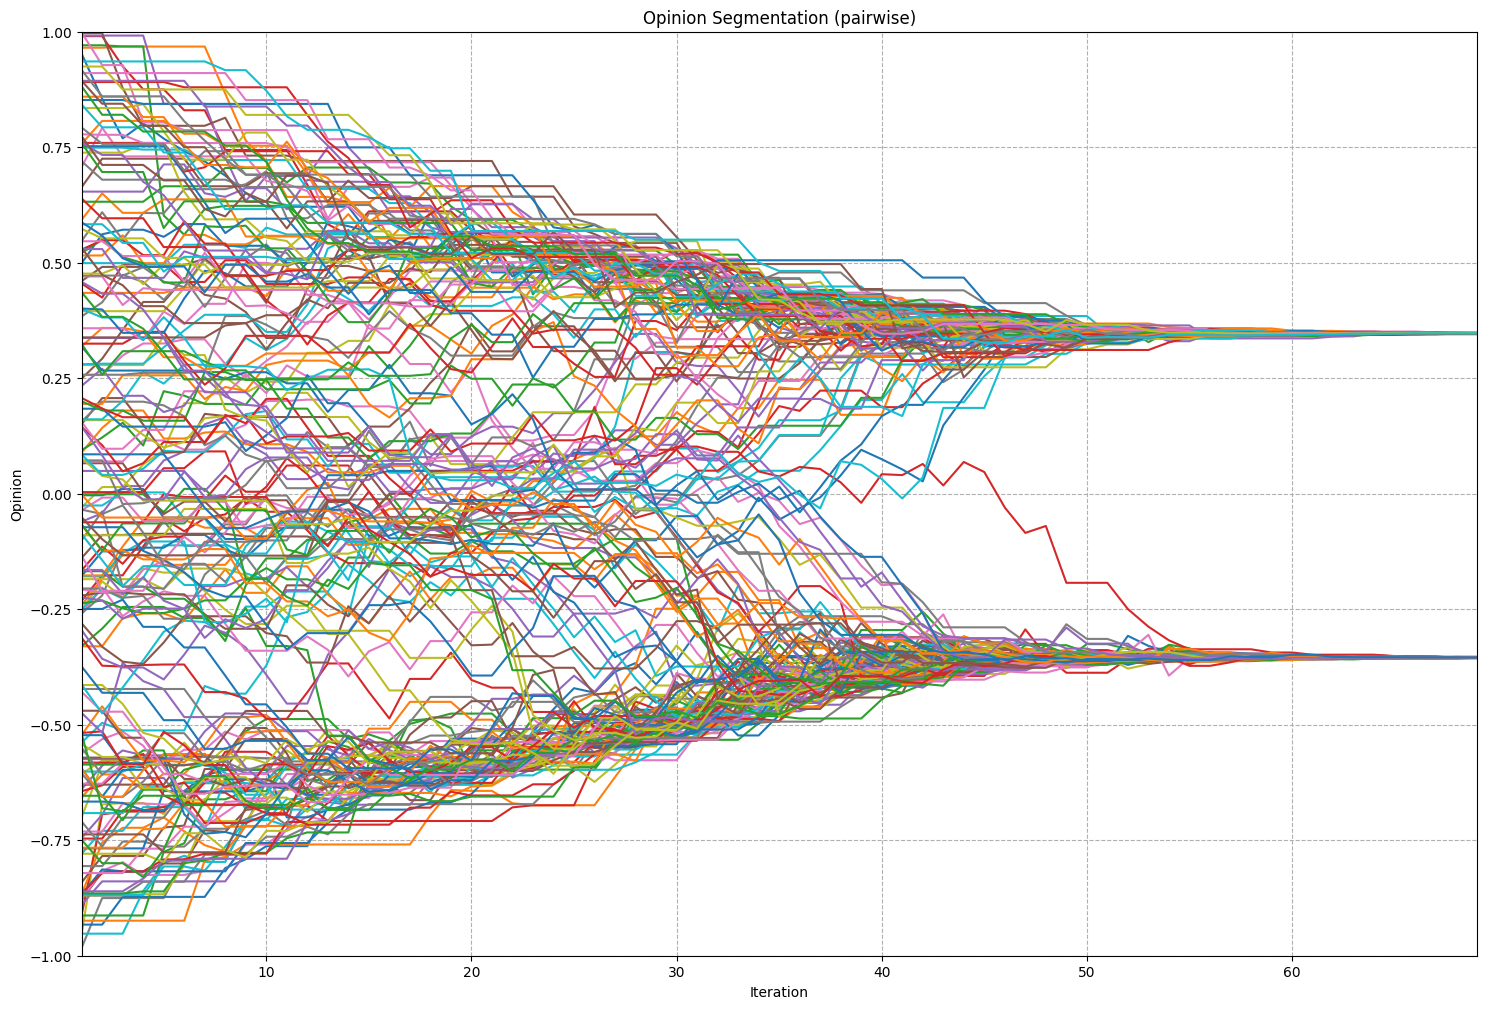

In [12]:
model = run_until_converge(n_agents=200)
plot_chart(model)


In [ ]:
params = {
    "percentage_extremists": np.array([0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
    "uncertainty_moderate": np.arange(0.2, 2.2, 0.2),
    "uncertainty_extremists": np.arange(0.05, 0.25, 0.05),
    "relative_difference_positive_negative_extrimists": np.arange(0, 0.6, 0.1),
    "intensity_interaction": np.arange(0.1, 0.6, 0.1)
}

In [ ]:
def compose_dataset(params, sample=0.05):
    columns = ['percentage_extremists', 'uncertainty_moderate', 'uncertainty_extremists',
               'relative_difference_positive_negative_extrimists', 'intensity_interaction']
    all_combinations = itertools.product(*[params[column] for column in columns])
    all_combinations = list(all_combinations)
    size_sample = len(all_combinations) * sample
    combinations = random.sample(all_combinations, int(size_sample))
    data = np.zeros((len(combinations), 5 + 1000))
    kwargs = lambda c: {
        'percentage_extremists': c[0],
        'uncertainty_moderate': c[1],
        'uncertainty_extremists': c[2],
        'relative_difference_positive_negative_extrimists': c[3],
        'intensity_interaction': c[4]}
    for idx, c in enumerate(tqdm(combinations)):
        for r in range(REPEATITIONS):
            model = run_until_converge(**kwargs(c))
            data[idx] += np.array([*c, *model.history[-1]])
        data[idx] /= REPEATITIONS
        df = pd.DataFrame(data=data, columns=columns + [f'a{i + 1}' for i in range(1000)])
        if not os.path.exists('./data'):
            os.makedirs('./data')
        filepath = os.path.join('./data', f'dataset.csv')
        df.to_csv(filepath)
    return df

In [ ]:
REPEATITIONS = 1
df = compose_dataset(params)

100%|██████████████████████████████████████| 420/420 [10:41:51<00:00, 91.70s/it]


Перейдем к метрике, которую предлагаю взять, вместо представленной в статье

Определим метрику, которая учитывает как долю агентов в кластерах, так и характеристики каждого кластера (координаты центроида), применяя взвешивание в зависимости от абсолютного значения центроида и нашего порога threshold

Пусть
$( C_i
)$ - центроид
$( i
)$-го кластера,
$( n_i
)$ - количество агентов в
$( i
)$-м кластере,
$( N_AGENTS
)$ - общее количество агентов,
$( threshold
)$ - порог.

Тогда метрика вычисляется по формуле:


$$ embedding = \sum_{i=1}^{n_{clusters}} \left(\frac{n_i}{N_{AGENTS}}\right)^2 \cdot \frac{I_i}{\sum_{i=1}^{n_{clusters}} \sqrt{|C_i|} \cdot I_i} $$

$$ I_i = \left(\frac{n_i}{N_{AGENTS}}\right)^2 \quad \text{if} \quad \sqrt{|C_i|} > threshold $$

$$ 1 \quad \text{otherwise} $$

In [13]:
def interpret(values):
    """Describe final distribution of opinions in terms of # of clusters,
    coordinates of centroids and # of agents in each cluster.
    """
    values = np.array(values).reshape(-1, 1)
    clustering = DBSCAN(eps=0.001, min_samples=2).fit(values)
    n_clusters = max(clustering.labels_) + 1
    centroids = np.zeros((n_clusters))
    n_agents = np.zeros((n_clusters))
    for cluster_idx in range(n_clusters):
        agents_ = values[clustering.labels_ == cluster_idx]
        centroids[cluster_idx] = np.mean(agents_)
        n_agents[cluster_idx] = len(agents_)
    interpretation = {
        "n_clusters": n_clusters,
        "centroids": centroids,
        "n_agents": n_agents
    }
    return interpretation

In [14]:
interpret(model.history[-1])


{'n_clusters': 2,
 'centroids': array([ 0.34713424, -0.3545145 ]),
 'n_agents': array([ 95., 105.])}

In [18]:
N_AGENTS = 1000

In [19]:
def create_embedding(values, threshold=0.8):
    """Create embedding of opinion segmentation in Deffuant model.
    """
    interpretation = interpret(values)
    numerator, denominator = 0, 0
    for centroid, n in zip(interpretation['centroids'], interpretation['n_agents']):
        propotion = n / N_AGENTS
        numerator_term = propotion
        denominator_term = abs(centroid)
        if denominator_term > threshold:
            numerator_term = numerator_term ** 2
            denominator_term = math.sqrt(denominator_term)
        numerator += numerator_term
        denominator += denominator_term
    embedding = numerator / denominator
    return embedding

In [20]:
create_embedding(model.history[-1])


0.2850429153330623

In [21]:
param1 = np.array([0.05, 0.4, 0.1, 0.3, 0.25])
param2 = np.array([0.05, 0.4, 0.15, 0.25, 0.25])
param3 = np.array([0.1, 0.2, 0.01, 0.25, 0.1])

In [22]:
def show_embedding(param1, param2):
    kwargs = lambda c: {
        'percentage_extremists': c[0],
        'uncertainty_moderate': c[1],
        'uncertainty_extremists': c[2],
        'relative_difference_positive_negative_extrimists': c[3],
        'intensity_interaction': c[4]}

    model1 = run_until_converge(**kwargs(param1))
    model2 = run_until_converge(**kwargs(param2))

    embed1 = create_embedding(model1.history[-1])
    embed2 = create_embedding(model2.history[-1])

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Embedding 1: {embed1:.3f}")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Opinion")
    ax1.plot(np.arange(1, len(model1.history) + 1), model1.history, '-')
    ax1.set_xlim([1, len(model1.history)])
    ax1.set_ylim([-1, 1])

    ax2.set_title(f"Embedding 2: {embed2:.3f}")
    ax2.grid(linestyle="--")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Opinion")
    ax2.plot(np.arange(1, len(model2.history) + 1), model2.history, '-')
    ax2.set_xlim([1, len(model2.history)])
    ax2.set_ylim([-1, 1])

    plt.show()

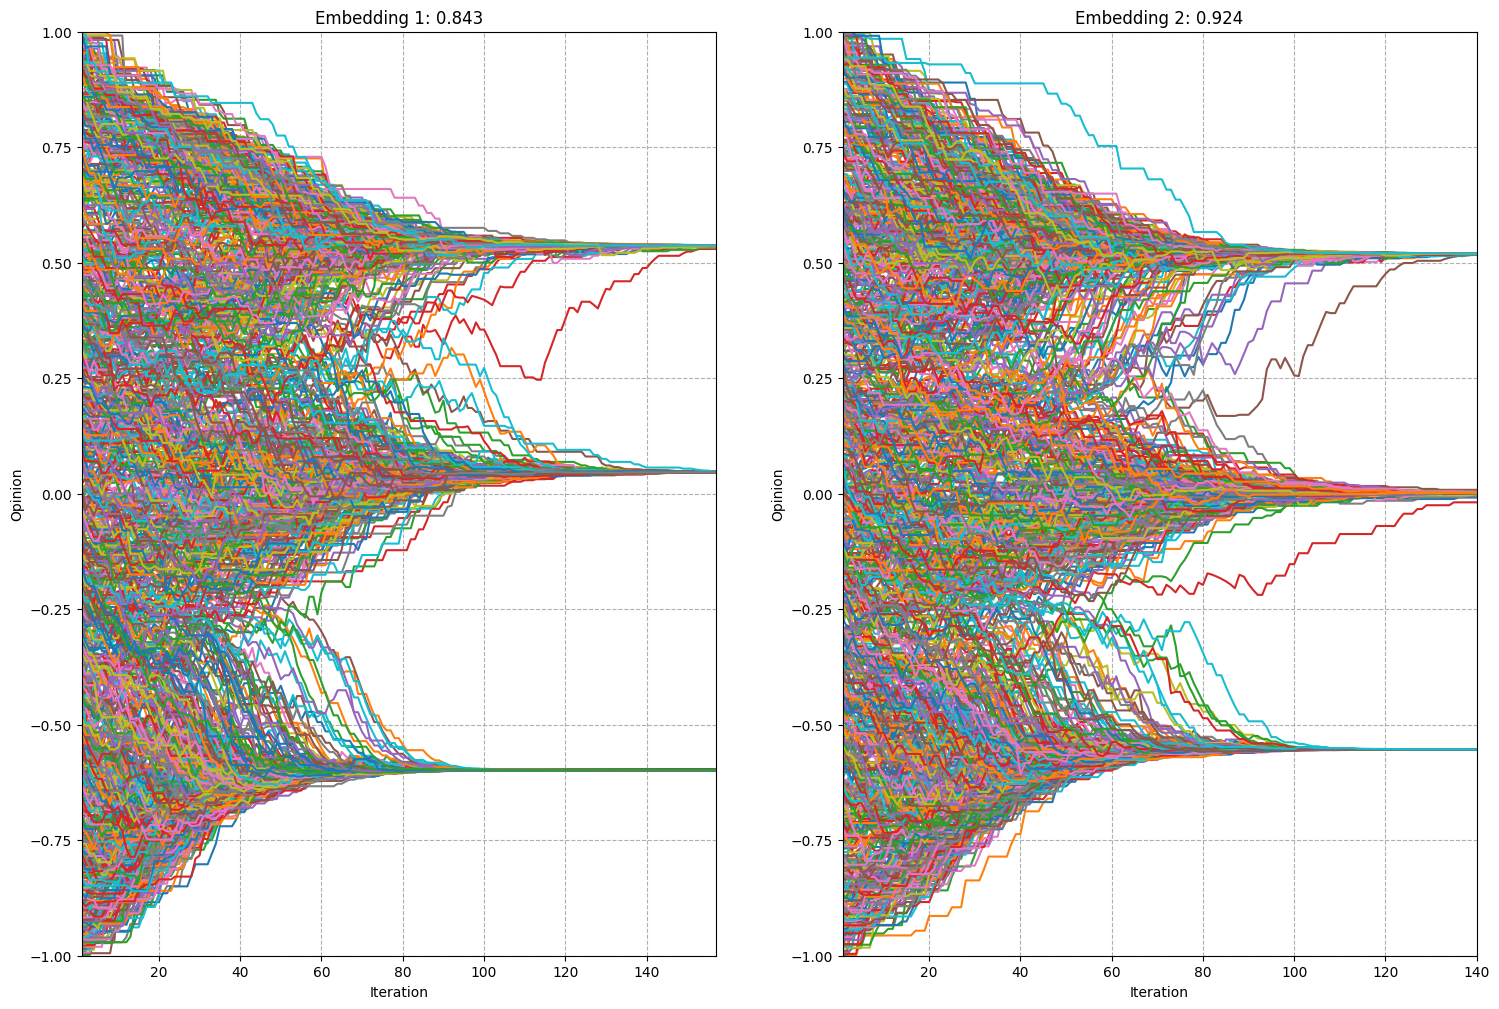

In [23]:
show_embedding(param1, param2)


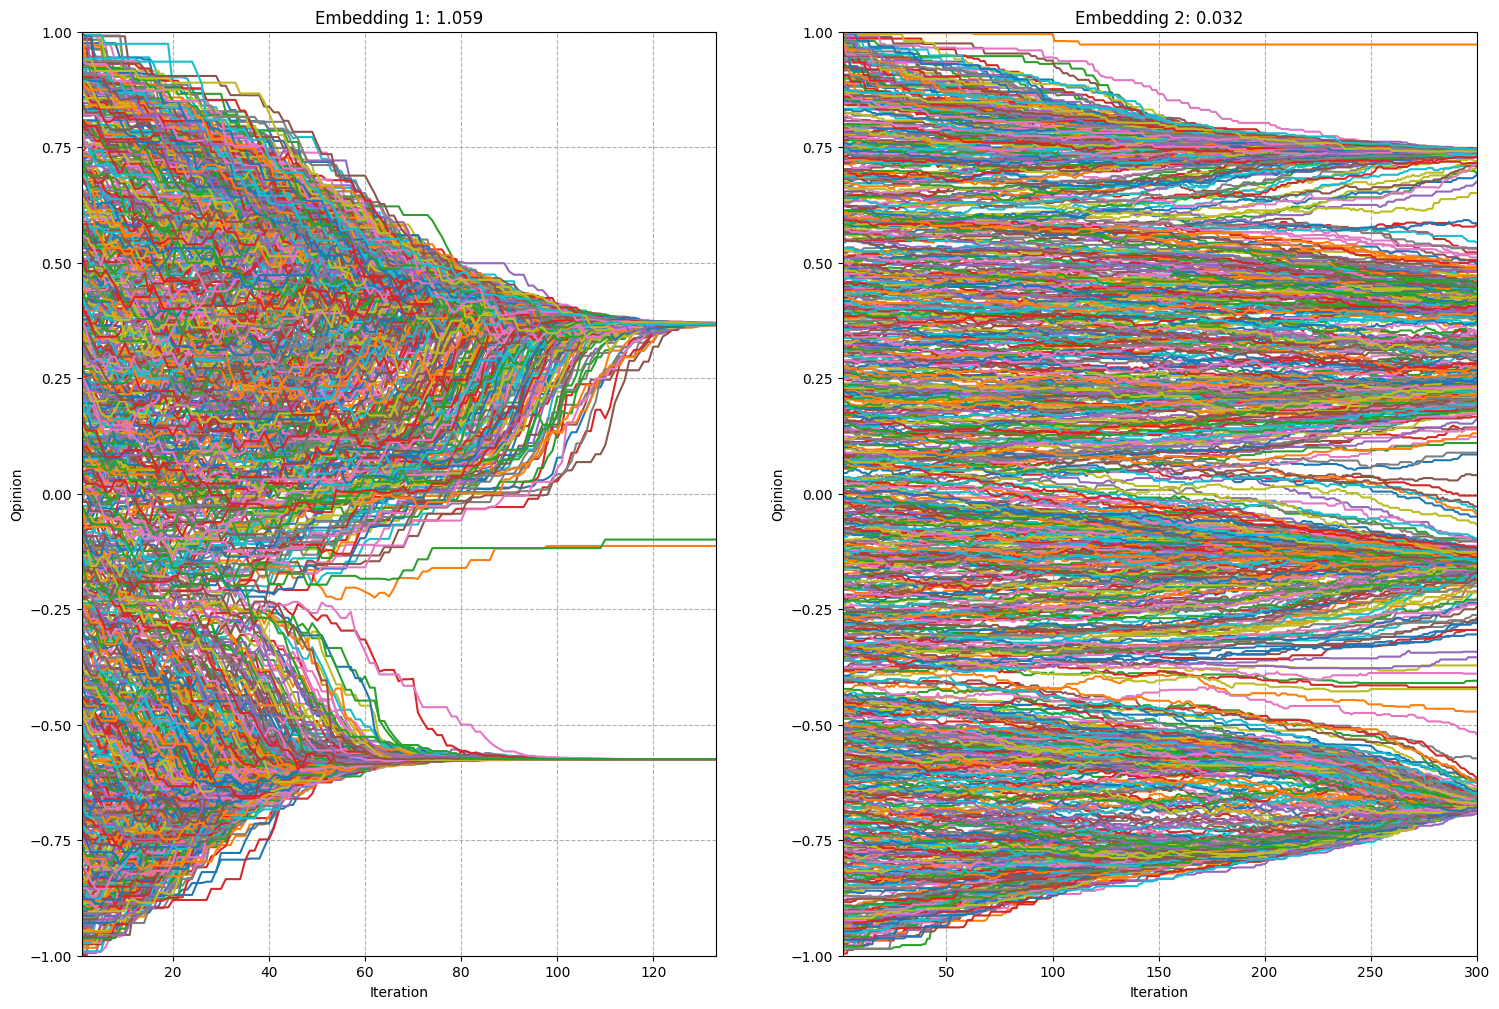

In [24]:
show_embedding(param1, param3)


Видим по картинкам, что наша метрика хорошо описывает похожие/ различные ситуации, корректно определяет количество кластеров

Перейдем к обучению модели

In [25]:
def embed_wrapper(row, threshold=0.8):
    columns = [f'a{i + 1}' for i in range(1000)]
    data = row[columns]
    embedding = create_embedding(data)
    return embedding

In [26]:
def embed_dataset(df):
    df['embedding'] = df.apply(embed_wrapper, axis=1)
    columns = [f'a{i + 1}' for i in range(1000)]
    df.drop(columns, axis=1).to_csv('./data/dataset_embedding.csv')
    return df

In [54]:
df = pd.read_csv('./data/dataset.csv').drop(columns=['Unnamed: 0'])
#df = pd.read_csv('./dataset.csv').drop(columns=['Unnamed: 0'])
df = embed_dataset(df)

In [55]:
df = pd.read_csv('./data/dataset_embedding.csv').drop(columns=['Unnamed: 0'])


In [56]:
df.head(10)

percentage_extremists  uncertainty_moderate  uncertainty_extremists  \
0                  0.025                   1.4                    0.05   
1                  0.150                   1.2                    0.05   
2                  0.250                   1.8                    0.10   
3                  0.100                   0.4                    0.10   
4                  0.050                   1.4                    0.20   
5                  0.100                   0.2                    0.20   
6                  0.250                   2.0                    0.10   
7                  0.025                   0.4                    0.15   
8                  0.300                   0.8                    0.10   
9                  0.200                   1.4                    0.10   

   relative_difference_positive_negative_extrimists  intensity_interaction  \
0                                               0.5                    0.5   
1                                               0.5                    0.5   
2                                               0.3                    0.3   
3                                               0.0                    0.2   
4                                               0.4                    0.5   
5                                               0.0                    0.4   
6                                               0.1                    0.5   
7                                               0.1                    0.4   
8                                               0.5                    0.5   
9                                               0.2                    0.1   

    embedding  
0  885.510766  
1   15.246534  
2   19.907788  
3    0.395188  
4  276.766910  
5    0.456166  
6   11.488726  
7    1.136065  
8    8.373914  
9   14.494189

In [57]:
display(df.dtypes)
df.isna().sum()

percentage_extremists                               float64
uncertainty_moderate                                float64
uncertainty_extremists                              float64
relative_difference_positive_negative_extrimists    float64
intensity_interaction                               float64
embedding                                           float64
dtype: object

percentage_extremists                               0
uncertainty_moderate                                0
uncertainty_extremists                              0
relative_difference_positive_negative_extrimists    0
intensity_interaction                               0
embedding                                           0
dtype: int64

In [94]:
y = df['embedding']
X = df[['percentage_extremists', 'uncertainty_moderate', 'uncertainty_extremists', 'relative_difference_positive_negative_extrimists', 'intensity_interaction']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


numeric_features = list(X_train.columns)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.8f" % mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Train RMSE = 4.53917290
Test RMSE = 4.13625761
Test R^2 = 0.60024542


In [99]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)


Best alpha = 10.00000000


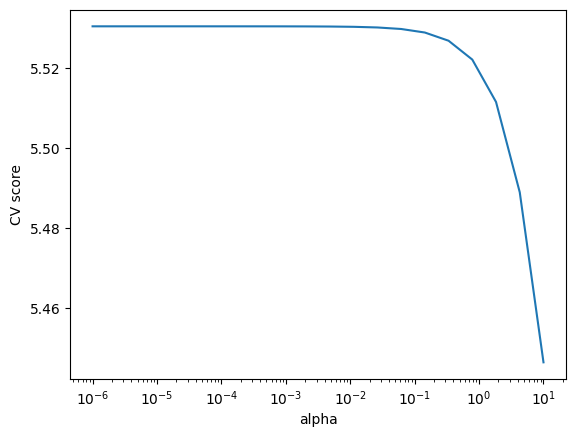

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

split_index = [-1 if x in X_train_new.index else 0 for x in X_train.index]
pds = PredefinedSplit(test_fold=split_index)

alphas = np.logspace(-6, 1, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [101]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 4.13169561
Test R^2 = 0.60112673


Best alpha = 0.78475997


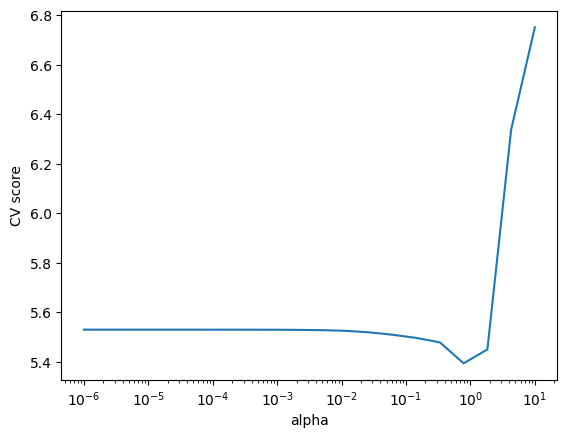

In [102]:
from sklearn.linear_model import Lasso
lasso_pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso())
])

searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha1 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha1)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [103]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso(best_alpha1))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 4.37992419


In [104]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, nthread=4, seed=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 2.73121614
Test R^2 = 0.82570279


In [88]:
xgb_model = xgb.XGBRegressor(nthread=4, seed=42)

x_train_test = np.vstack((X_train, X_test))
y_train_test = np.hstack((y_train, y_test))
split_index1 = [-1 if i in range(X_train.shape[0]) else 0 for i in range(x_train_test.shape[0])]
pd1 = PredefinedSplit(test_fold = split_index1)

param_grid1 = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.025, 0.05, 0.15],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'max_depth': [3, 4, 7],
    'reg_lambda': [0.5, 1.0, 1.2],
    'reg_alpha': [0.5, 1.0, 1.2],
    'subsample': [0.3, 0.5, 0.7]
}

clf = GridSearchCV(xgb_model, param_grid=param_grid1, scoring='neg_root_mean_squared_error', cv=pd1, n_jobs=-1)
clf.fit(x_train_test, y_train_test)
print('Best params:', clf.best_params_)
print('Best score:', -clf.best_score_)

KeyboardInterrupt: 

In [105]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

y = df['embedding']
X = df[['percentage_extremists', 'uncertainty_moderate', 'uncertainty_extremists', 'relative_difference_positive_negative_extrimists', 'intensity_interaction']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
numeric_features = list(X_train.columns)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', SVR())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.8f" % mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % r2_score(y_test, y_pred))


Train RMSE = 4.55462513
Test RMSE = 3.91390789
Test R^2 = 0.64206885


In [106]:
param1_reshaped = param1.reshape(1, -1)
param2_reshaped = param2.reshape(1, -1)

predictions_param1 = xgb_model.predict(param1_reshaped)
predictions_param2 = xgb_model.predict(param2_reshaped)



print("Предсказанные значения для param1:", predictions_param1)
print("Предсказанные значения для param2:", predictions_param2)
print("Разница между предсказанными метриками:", predictions_param1 - predictions_param2)

Предсказанные значения для param1: [0.4845394]
Предсказанные значения для param2: [0.35980615]
Разница между предсказанными метриками: [0.12473324]


Видим, что модель хорошо предсказывает значения для схожих ситуаций финального распределения